In [1]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler


In [2]:
from core.cluster_validation import generate_validation_groups, colored_crosstab
from core.utils import used_keys

In [3]:
import umap
import umap.plot
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

In [4]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [5]:
# region_id = 4182

# tessellations_dir = graph_dir = '../data/ms_buildings/'
# chars_dir = '../data/ms_buildings/chars/'

In [6]:
primary = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [7]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

### Generate context

In [8]:
@numba.njit(parallel=True)
def numba_limit_range(rows, cols, partial_vals, output_vals):
    # print(partial_vals)
    ngroups = int(rows[-1]) + 1
    nrows = rows.shape[0]
    result = np.empty((ngroups, partial_vals.shape[1] * output_vals))

    istart = 0
    for g in range(ngroups):
        # # find focal start
        # istart = 0
        # while istart < nrows and rows[istart] != g:
        #     istart += 1

        # find neighbors
        iend = istart + 1
        while iend < nrows and rows[iend - 1] == rows[iend]:
            iend += 1

        ## for every column apply iqr and percentiles
        for c in numba.prange(partial_vals.shape[1]):
            col_vals = partial_vals[cols[istart:iend], c]
            res_index = output_vals * c

            if np.isnan(col_vals).all():
                result[g, res_index] = np.nan
                result[g, res_index + 1] = np.nan
                result[g, res_index + 2] = np.nan
                continue

            lower, med, higher = np.nanpercentile(col_vals, (15, 50, 85))
            result[g, res_index] = lower
            result[g, res_index + 1] = med
            result[g, res_index + 2] = higher

        # # go to next group
        istart = iend
    return result

In [9]:
def parallel_higher_order_context(df, graph, k, n_splits, output_vals):
    A = graph.transform("B").sparse
    ids = graph.unique_ids.values
    rows = np.arange(A.shape[0])
    values = df.values

    final_result = pd.DataFrame(
        np.empty((values.shape[0], values.shape[1] * output_vals)), index=ids
    )

    for source in np.array_split(rows, n_splits):
        Q = A[source, :].copy()
        for _ in range(1, k):
            next_step = Q @ A
            Q += next_step

        sparray = Q.tocoo(copy=False)
        sorter = sparray.row.argsort()
        unique_tail = np.unique(sparray.col)
        partial_vals = values[unique_tail, :]

        cols_dict = pd.Series(np.arange(len(unique_tail)), index=unique_tail)
        columns_to_pass = cols_dict.loc[sparray.col].values
        rows_to_pass = sparray.row[sorter]

        partial_res = numba_limit_range(
            rows_to_pass, columns_to_pass, partial_vals, output_vals
        )

        final_result.iloc[source, :] = partial_res

    return final_result

In [10]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [36]:
# graph.cardinalities.describe()

count    304554.000000
mean          6.751085
std           2.060782
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          82.000000
Name: cardinalities, dtype: float64

In [37]:
# graph.higher_order(lower_order=True, k=2, diagonal=True).cardinalities.describe()

count    304554.000000
mean         21.093776
std           7.825243
min           1.000000
25%          17.000000
50%          20.000000
75%          24.000000
max         241.000000
Name: cardinalities, dtype: float64

In [38]:
# graph.higher_order(lower_order=True, k=3, diagonal=True).cardinalities.describe()

count    304554.000000
mean         46.254464
std          19.844657
min           1.000000
25%          35.000000
50%          43.000000
75%          53.000000
max         396.000000
Name: cardinalities, dtype: float64

In [11]:
## Discard disconnected components and focus on a single component only.
## doesnt make a big difference.

In [12]:
graph.component_labels.value_counts()

component labels
25     176892
24      19069
28       3958
69       3867
99       3368
        ...  
766         1
798         1
799         1
800         1
814         1
Name: count, Length: 815, dtype: int64

cluster only the data from the first component

In [13]:
# data = primary.loc[component_labels]
# data_graph = graph.subgraph(component_labels)
# component_labels = graph.component_labels.copy()
# component_labels = component_labels[component_labels == 0].index.values

cluster only buildings tessellation cells

In [14]:
# data = primary.loc[primary.index >= 0]
# data_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])

In [124]:
data = primary
data_graph = graph

In [125]:
spatial_lag = 3
spatial_lag

3

In [126]:
%%time
context = parallel_higher_order_context(
    data, data_graph, k=spatial_lag, n_splits=10, output_vals=3
)

CPU times: user 2min 21s, sys: 10.7 s, total: 2min 32s
Wall time: 13.3 s


In [127]:
context.columns = np.concatenate(
    [(c + "_lower", c + "_median", c + "_higher") for c in primary.columns]
)

In [128]:
# X = context

In [129]:
# higher = graph.higher_order(k=3, lower_order=True, diagonal=True)
# r = higher.describe(primary['sdbAre'], statistics=['median'])['median']
# from pandas.testing import assert_series_equal
# assert_series_equal(context['sdbAre_median'], r, check_names=False)

# r.duplicated().sum()

### Data preprocessing

In [130]:
tess_groups = generate_validation_groups(tessellation, include_random_sample=True)

def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [131]:
## no spatial lag
X = np.nan_to_num(StandardScaler().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(5.708873645593739)

In [132]:
## no spatial lag
X = np.nan_to_num(RobustScaler().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(7.112267943703283)

In [133]:
## no spatial lag
X = np.nan_to_num(PowerTransformer().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(5.835087847819378)

In [134]:
### only medians

In [135]:
X = np.nan_to_num(
    StandardScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(3.9347153449030117)

In [136]:
X = np.nan_to_num(
    RobustScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(4.100120018386263)

In [137]:
X = np.nan_to_num(
    PowerTransformer().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")] + 1
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(3.7645759427204157)

In [138]:
## clip medians to -10, 10 standard deviations
X = np.nan_to_num(
    StandardScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
X = X.clip(-10, 10)
check_score(X, tess_groups)

np.float64(3.869738902581256)

In [139]:
# all features with lag

In [140]:
# no standardisation
X = np.nan_to_num(context)
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(6.974679017317933)

In [141]:
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(3.829752323997001)

In [142]:
X = np.nan_to_num(RobustScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(4.299996608572109)

In [143]:
X = np.nan_to_num(PowerTransformer().fit_transform(context + 1))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(3.677874713624734)

In [144]:
## clip to -10, 10 standard deviations
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
X = X.clip(-10, 10)
check_score(X, tess_groups)

np.float64(3.770869996915311)

In [145]:
context["sdbAre_lower"].describe()

count    304535.000000
mean         54.372699
std         105.513203
min           1.217754
25%          27.258063
50%          39.660908
75%          65.944507
max       51138.982516
Name: sdbAre_lower, dtype: float64

In [146]:
desc = X.describe()

In [147]:
desc.loc[["25%", "50%", "75%", "max"]]

sdbAre_lower  sdbAre_median  sdbAre_higher  sdbPer_lower  sdbPer_median  \
25%     -0.256973      -0.284940      -0.310048     -0.706333      -0.504532   
50%     -0.139403      -0.131613      -0.218757     -0.253764      -0.157214   
75%      0.109664       0.091779       0.002078      0.476756       0.367966   
max     10.000000      10.000000      10.000000     10.000000      10.000000   

     sdbPer_higher  sdbCoA_lower  sdbCoA_median  sdbCoA_higher  ssbCCo_lower  \
25%      -0.530915           0.0            0.0      -0.033899     -0.697595   
50%      -0.290075           0.0            0.0      -0.033899      0.074587   
75%       0.176147           0.0            0.0      -0.033899      0.734214   
max      10.000000           0.0            0.0      10.000000      7.733038   

     ...  ltkOri_higher  ltkWNB_lower  ltkWNB_median  ltkWNB_higher  \
25%  ...      -0.774082     -0.736189      -0.809199      -0.660770   
50%  ...       0.051943     -0.334617      -0.245281      -0.109070   
75%  ...       0.857125      0.465915       0.622580       0.509013   
max  ...       1.587848     10.000000      10.000000      10.000000   

     likWBB_lower  likWBB_median  likWBB_higher  sdsAre_lower  sdsAre_median  \
25%     -0.699154      -0.732915      -0.687672     -0.253125      -0.337031   
50%     -0.214258      -0.162823      -0.128456     -0.209479      -0.257799   
75%      0.445566       0.437370       0.393366     -0.102722      -0.079201   
max      6.406657       5.182620       4.667839     10.000000      10.000000   

     sdsAre_higher  
25%      -0.414252  
50%      -0.304489  
75%      -0.018030  
max      10.000000  

[4 rows x 186 columns]

In [148]:
corrs = context.corr().abs()
upper = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))

In [149]:
corrs_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
corrs_to_drop

['ssbCCM_lower',
 'ssbCCM_median',
 'linP4W_median',
 'linP4W_higher',
 'lcnClo_higher',
 'ldkPer_lower',
 'ldkPer_median',
 'lskCWA_lower',
 'lskCWA_median',
 'lskCWA_higher']

In [150]:
X_no_corr = X.drop(columns=corrs_to_drop)
X_no_corr.shape, check_score(X_no_corr, tess_groups)

((304554, 176), np.float64(3.7766598799092685))

In [151]:
# corrs_to_drop = []
# X_no_corr = X.drop(columns=corrs_to_drop)
# X_no_corr.shape, check_score(X_no_corr, tess_groups)

In [152]:
# X.describe()

In [153]:
desc = X_no_corr.describe()
to_drop = desc.columns[(desc.loc["max"] - desc.loc["min"]) < 0.5].values
to_drop

array(['sdbCoA_lower', 'sdbCoA_median'], dtype=object)

In [154]:
X_different = X_no_corr.drop(columns=to_drop)
X_different.shape, check_score(X_different, tess_groups)

((304554, 174), np.float64(3.7766598799092668))

In [155]:
X_no_duplicates = X_different[~X_different.duplicated()]
X_no_duplicates.shape, check_score(X_no_duplicates, tess_groups)

((291564, 174), np.float64(3.7188879856331476))

In [156]:
# tessellation[X_different.duplicated(keep=False)].explore()

In [157]:
# plotting = tessellation.loc[X_different[X_different.duplicated(keep=False)].index.values]
# plotting['sdbAre_lower'] = X_different[X_different.duplicated(keep=False)]['sdbAre_lower']
# plotting = plotting.sort_values('sdbAre_lower')
# plotting['sdbAre_lower']

In [158]:
# layer = PolygonLayer.from_geopandas(
#     gdf=plotting.reset_index()[['geometry', 'index', 'sdbAre_lower']],
#     opacity=.15
# )
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [159]:
# tessellation.loc[graph[250196].index.values].reset_index().explore()

In [160]:
# tessellation.loc[higher[21149].index.values, ].explore()

In [161]:
# tessellation.loc[higher[271717].index.values, ].explore()

In [162]:
# higher = graph.higher_order(k=3, lower_order=True, diagonal=True)

In [163]:
# primary.loc[higher[271717].index.values, 'sdbAre'].median(), primary.loc[higher[271714].index.values, 'sdbAre'].median()

In [164]:
# primary.loc[higher[271717].index.values, 'sdbAre'].describe()

In [165]:
# primary.loc[higher[271714].index.values, 'sdbAre'].describe()

In [166]:
# r = dict([])
# for idx in higher[271717].index.values:
#     r[idx] = (primary.loc[higher[idx].index.values, 'sdbAre'].median())

In [167]:
# dict(sorted(r.items(), key=lambda item: item[1]))

In [168]:
# remove singletons

In [169]:
singletons = graph.unique_ids[graph.cardinalities == 1]

In [170]:
# tessellation.loc[singletons].explore()

In [171]:
X_no_singletons = X_no_duplicates[~X_no_duplicates.index.isin(singletons)]
X_no_singletons.shape, check_score(X_no_singletons, tess_groups)

((291401, 174), np.float64(3.7159105245472066))

In [172]:
# remove empty space

In [173]:
X_buildings = X_no_singletons[X_no_singletons.index >= 0]
X_buildings.shape, check_score(X_buildings, tess_groups)

((286282, 174), np.float64(3.682170318892562))

In [174]:
X_train = X_buildings
X_train.shape, check_score(X_train, tess_groups)

((286282, 174), np.float64(3.682170318892562))

In [175]:
X_train.describe().loc["max"].describe()

count    174.000000
mean       7.399323
std        3.096730
min        0.204184
25%        4.871074
50%        9.291028
75%       10.000000
max       10.000000
Name: max, dtype: float64

In [176]:
X_train.to_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

In [177]:
# X_train = pd.read_parquet('/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}.parquet')

### UMAP tests

In [69]:
# X_train = pd.read_parquet('/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}.parquet')

In [10]:
tess_groups = generate_validation_groups(tessellation, 
                                         include_random_sample=True,
                                         random_sample_size=2_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

In [11]:
def print_umap(embedding_df, title):
    gb_cols = Set3_12.hex_colors

    embedding_groups = embedding_df.groupby("neighbourhood")

    gnames = embedding_df["neighbourhood"].unique()
    genums = np.arange(len(gnames))

    fig, ax = plt.subplots(figsize=(10, 10))

    for genum, gname in zip(genums, gnames, strict=False):
        color = gb_cols[genum]
        label = gname
        es_ = embedding_groups.get_group(gname).values[:, :2]
        ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)
    ax.legend()
    ax.set_title(title)
    return ax

In [12]:
def show_nn(n_neighbors, n_components, n_epochs, min_dist):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_epochs=n_epochs,
    )
    embedding = reducer.fit_transform(X_train.iloc[tess_groups_ilocs])

    embedding_df = pd.DataFrame(embedding, index=tess_groups.index)
    embedding_df["neighbourhood"] = tess_groups.values

    print(
        n_neighbors,
        n_components,
        n_epochs,
        min_dist,
        "--",
        davies_bouldin_score(embedding, tess_groups.values),
    )

    if n_components == 2:
        return umap.plot.points(reducer, labels=tess_groups.values)
    else:
        return None

15 2 100 0.1 -- 1.862420740336959
25 2 100 0.1 -- 1.4641511370725777
50 2 100 0.1 -- 1.6539619376074237
100 2 100 0.1 -- 1.5007733090701163


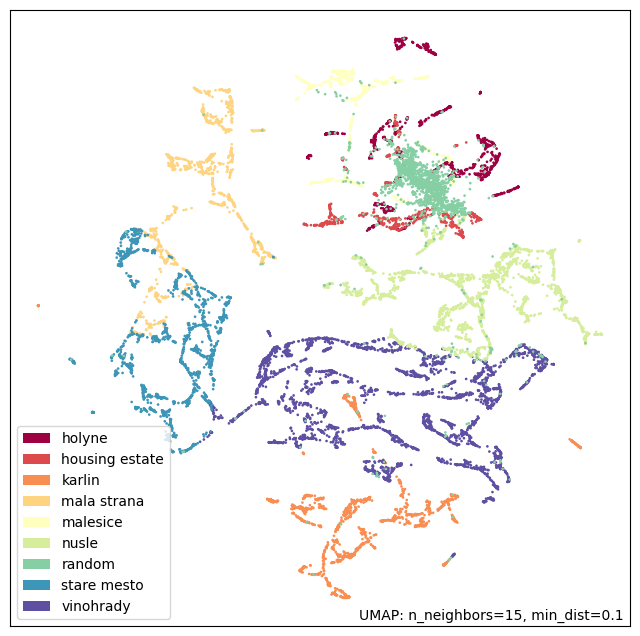

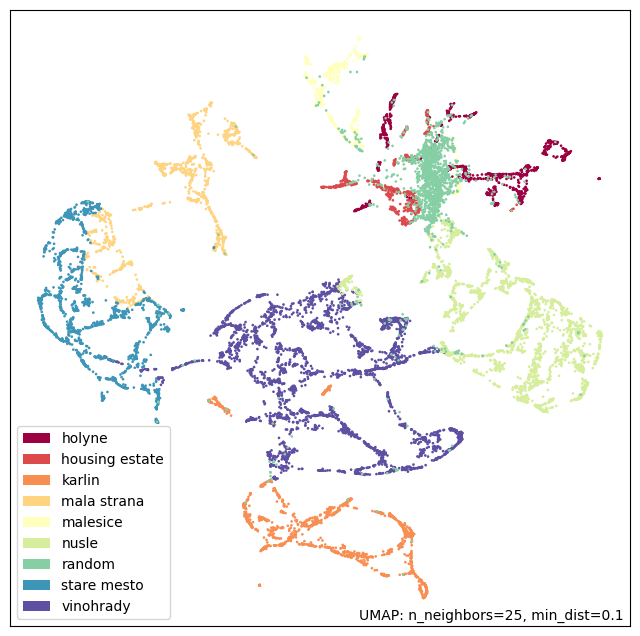

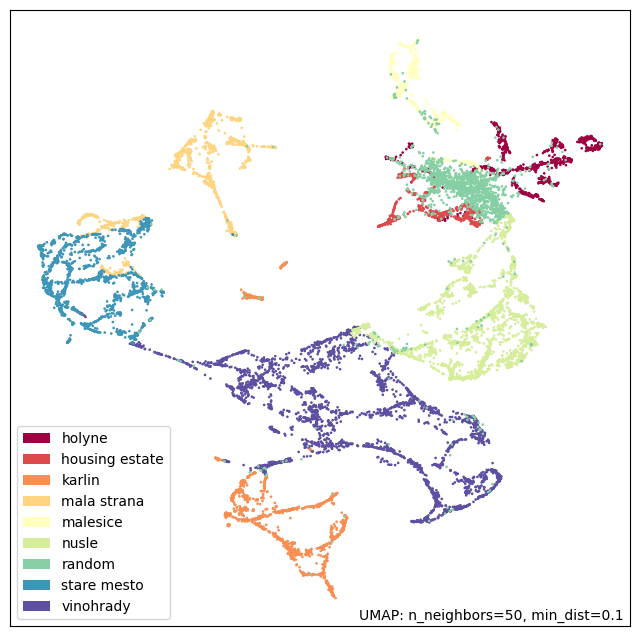

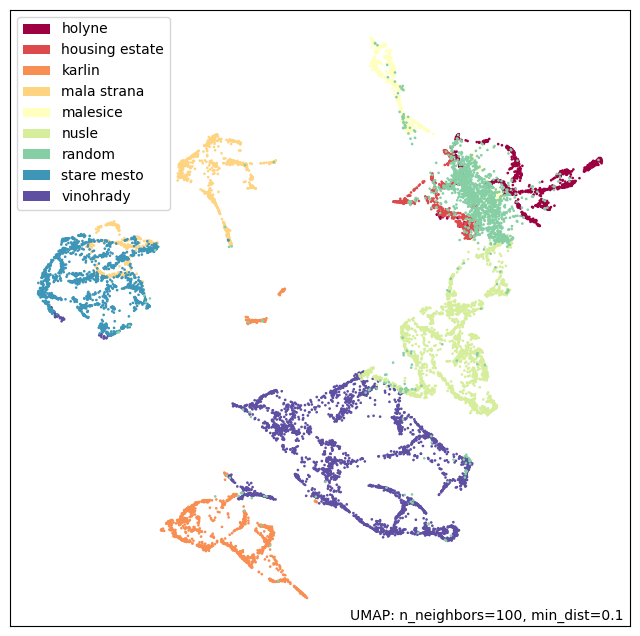

In [13]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.1)

In [46]:
# for n_neighbors in [15, 25, 50, 100]:
#     for n_components in [5, 10, 15]:
#         show_nn(
#             n_neighbors=n_neighbors,
#             n_components=n_components,
#             n_epochs=500,
#             min_dist=0.1,
#         )

15 5 500 0.1 -- 1.4127280161498468
15 10 500 0.1 -- 1.335989354088617
15 15 500 0.1 -- 1.3167221667416629
25 5 500 0.1 -- 1.5001688901799717
25 10 500 0.1 -- 1.3345047808691204
25 15 500 0.1 -- 1.3158634415453951
50 5 500 0.1 -- 1.4639661554549583
50 10 500 0.1 -- 1.4012411750528682
50 15 500 0.1 -- 1.4340224511662558
100 5 500 0.1 -- 1.4749527721376092
100 10 500 0.1 -- 1.4680293072856825
100 15 500 0.1 -- 1.4717436010225011


In [68]:
# for n_neighbors in [30, 100]:
#     for n_components in [5, 10, 15]:
#         for min_dist in [0.0, 0.05, 0.1]:
#             show_nn(
#                 n_neighbors=n_neighbors,
#                 n_components=n_components,
#                 n_epochs=500,
#                 min_dist=min_dist,
#             )

In [9]:
assert not X_train.duplicated().any()

In [10]:
reducer = umap.UMAP(n_neighbors=25, n_components=15, min_dist=0, verbose=True)
embedding = reducer.fit_transform(X_train)

UMAP(min_dist=0, n_components=15, n_neighbors=25, verbose=True)
Sun Jul 21 16:06:05 2024 Construct fuzzy simplicial set
Sun Jul 21 16:06:05 2024 Finding Nearest Neighbors
Sun Jul 21 16:06:05 2024 Building RP forest with 31 trees
Sun Jul 21 16:06:09 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	Stopping threshold met -- exiting after 2 iterations
Sun Jul 21 16:06:20 2024 Finished Nearest Neighbor Search
Sun Jul 21 16:06:22 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jul 21 16:13:40 2024 Finished embedding


### Umap visualisations


In [204]:
viz_reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, verbose=True)
viz_embedding = viz_reducer.fit_transform(X_train)

UMAP(n_neighbors=30, verbose=True)
Thu Jul 18 18:35:47 2024 Construct fuzzy simplicial set
Thu Jul 18 18:35:47 2024 Finding Nearest Neighbors
Thu Jul 18 18:35:47 2024 Building RP forest with 31 trees
Thu Jul 18 18:35:49 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	Stopping threshold met -- exiting after 2 iterations
Thu Jul 18 18:35:58 2024 Finished Nearest Neighbor Search
Thu Jul 18 18:35:59 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul 18 18:43:08 2024 Finished embedding


In [205]:
embedding_df = pd.DataFrame(embedding[tess_groups_ilocs, :3], index=tess_groups.index)
embedding_df["neighbourhood"] = tess_groups.values

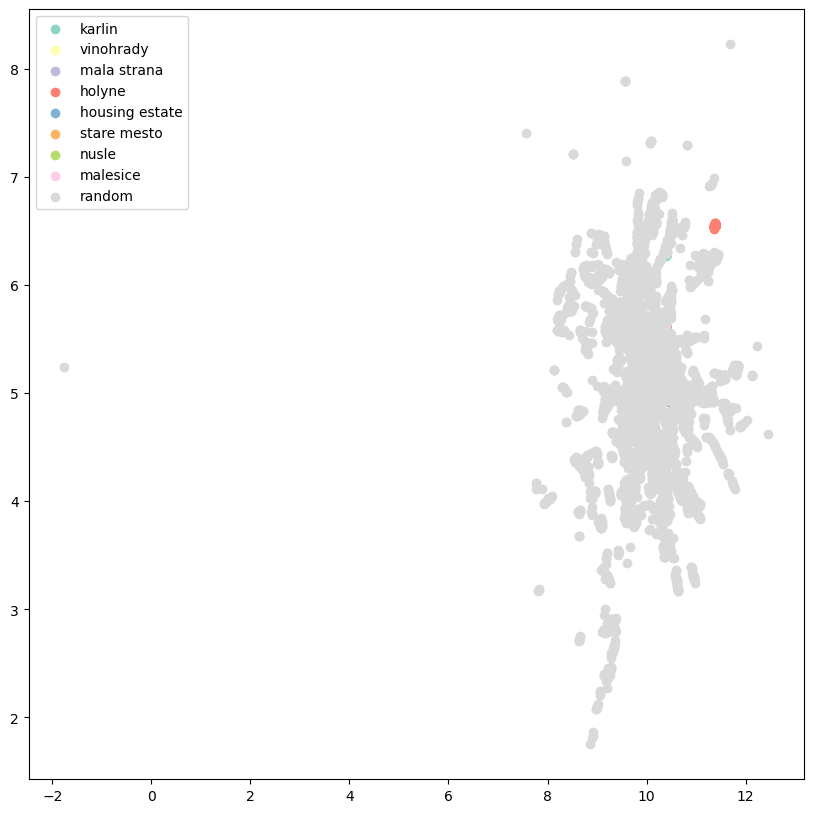

In [206]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")

gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig, ax = plt.subplots(figsize=(10, 10))

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :2]
    ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)
ax.legend()

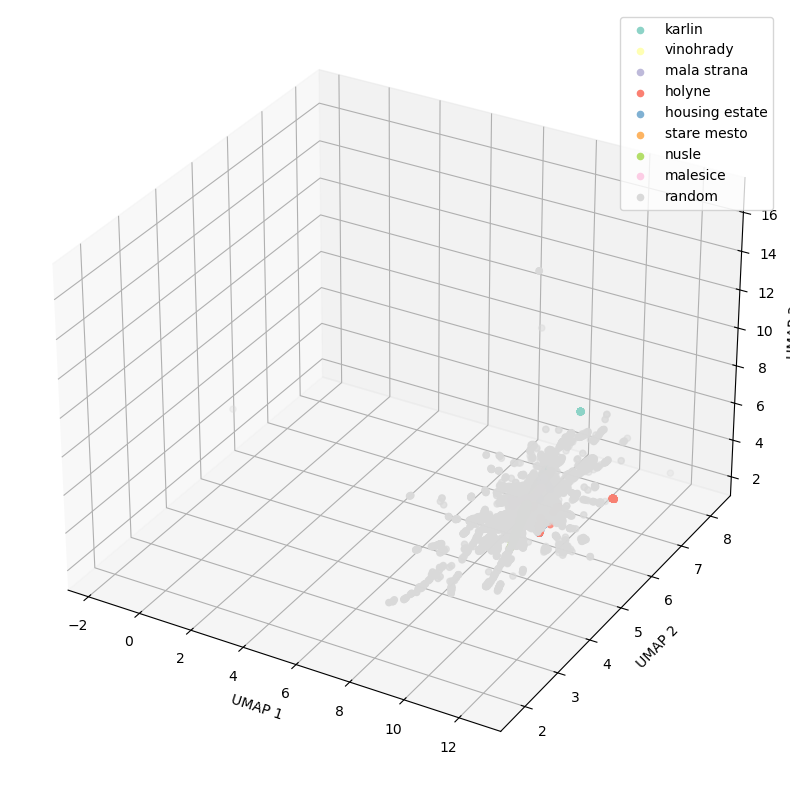

In [207]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:, 0], es_[:, 1], es_[:, 2], color=color, label=label)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()

In [208]:
# ax.view_init(45, 45)
# fig

In [209]:
# ax.view_init(45, 90)
# fig

In [210]:
# ax.view_init(45, 135)
# fig

In [211]:
davies_bouldin_score(embedding[tess_groups_ilocs, :], tess_groups.values)

np.float64(1.7092035811008213)

<Axes: >

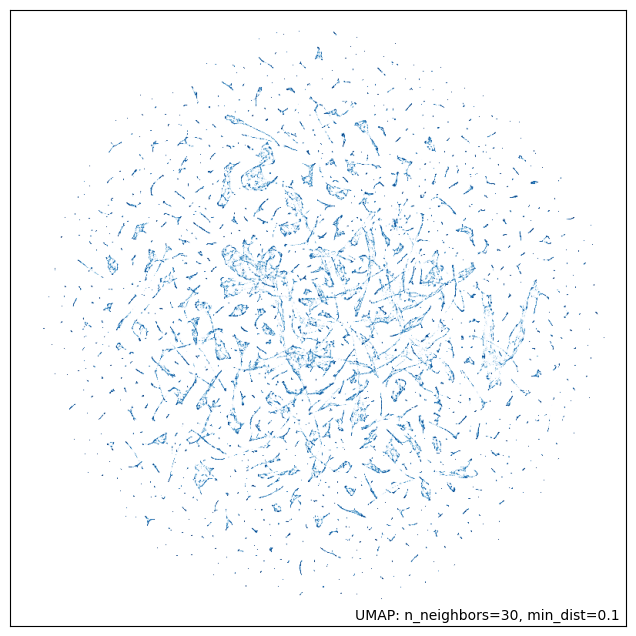

In [212]:
umap.plot.points(viz_reducer)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

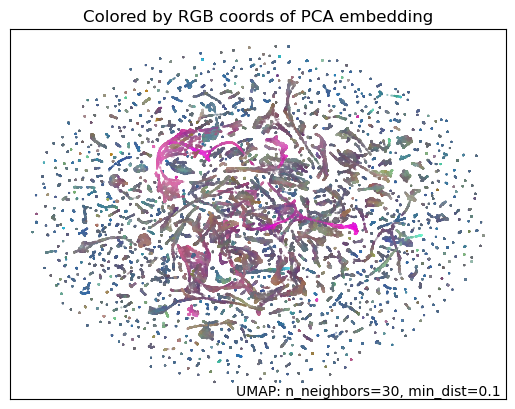

In [81]:
umap.plot.diagnostic(viz_reducer, diagnostic_type="pca")

<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

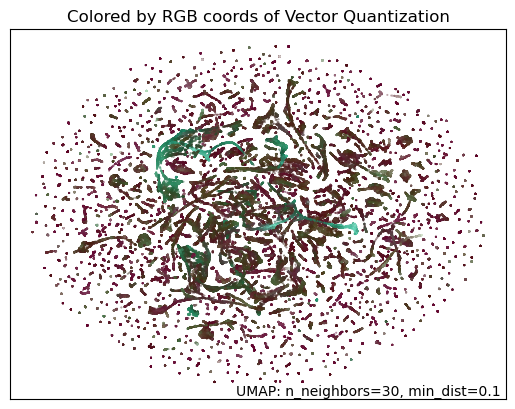

In [82]:
umap.plot.diagnostic(viz_reducer, diagnostic_type="vq")

Mon Jul  1 13:13:28 2024 Worst tree score: 0.91919930
Mon Jul  1 13:13:28 2024 Mean tree score: 0.92128518
Mon Jul  1 13:13:28 2024 Best tree score: 0.92306057
Mon Jul  1 13:13:30 2024 Forward diversification reduced edges from 7761690 to 1122124
Mon Jul  1 13:13:31 2024 Reverse diversification reduced edges from 1122124 to 1122124
Mon Jul  1 13:13:32 2024 Degree pruning reduced edges from 1054788 to 1054788
Mon Jul  1 13:13:32 2024 Resorting data and graph based on tree order
Mon Jul  1 13:13:32 2024 Building and compiling search function


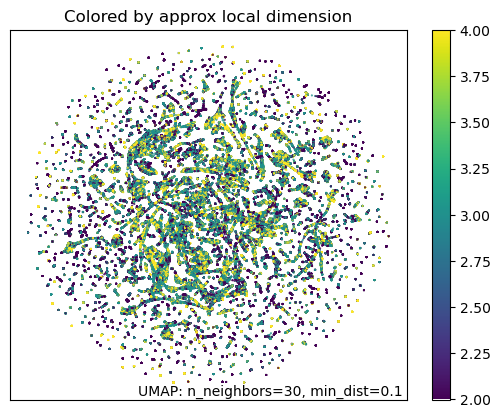

In [83]:
local_dims = umap.plot.diagnostic(viz_reducer, diagnostic_type="local_dim")

In [ ]:
### paint the UMAP embeddings by prague district

In [213]:
czech_admin = (
    gpd.read_file("../../notebooks/data/MAP_CUR_MAP_MESTSKECASTI_P.zip")
    .sort_values("KOD_MC")
    .reset_index(drop=True)
)
admin_id, tess_id = tessellation.loc[X_train.index].sindex.query(
    czech_admin.geometry.to_crs(tessellation.crs), predicate="intersects"
)
import glasbey

gb_cols = glasbey.extend_palette(Set3_12.hex_colors, palette_size=max(admin_id) + 1)
czech_admin["color"] = gb_cols
labels = pd.Series("Bohemia", index=X_train.index)
labels.iloc[tess_id] = czech_admin.iloc[admin_id]["NAZEV_MC"].values
cmap = dict(zip(czech_admin["NAZEV_MC"].values, gb_cols, strict=False))
cmap["Bohemia"] = "#ffffff"

<Axes: >

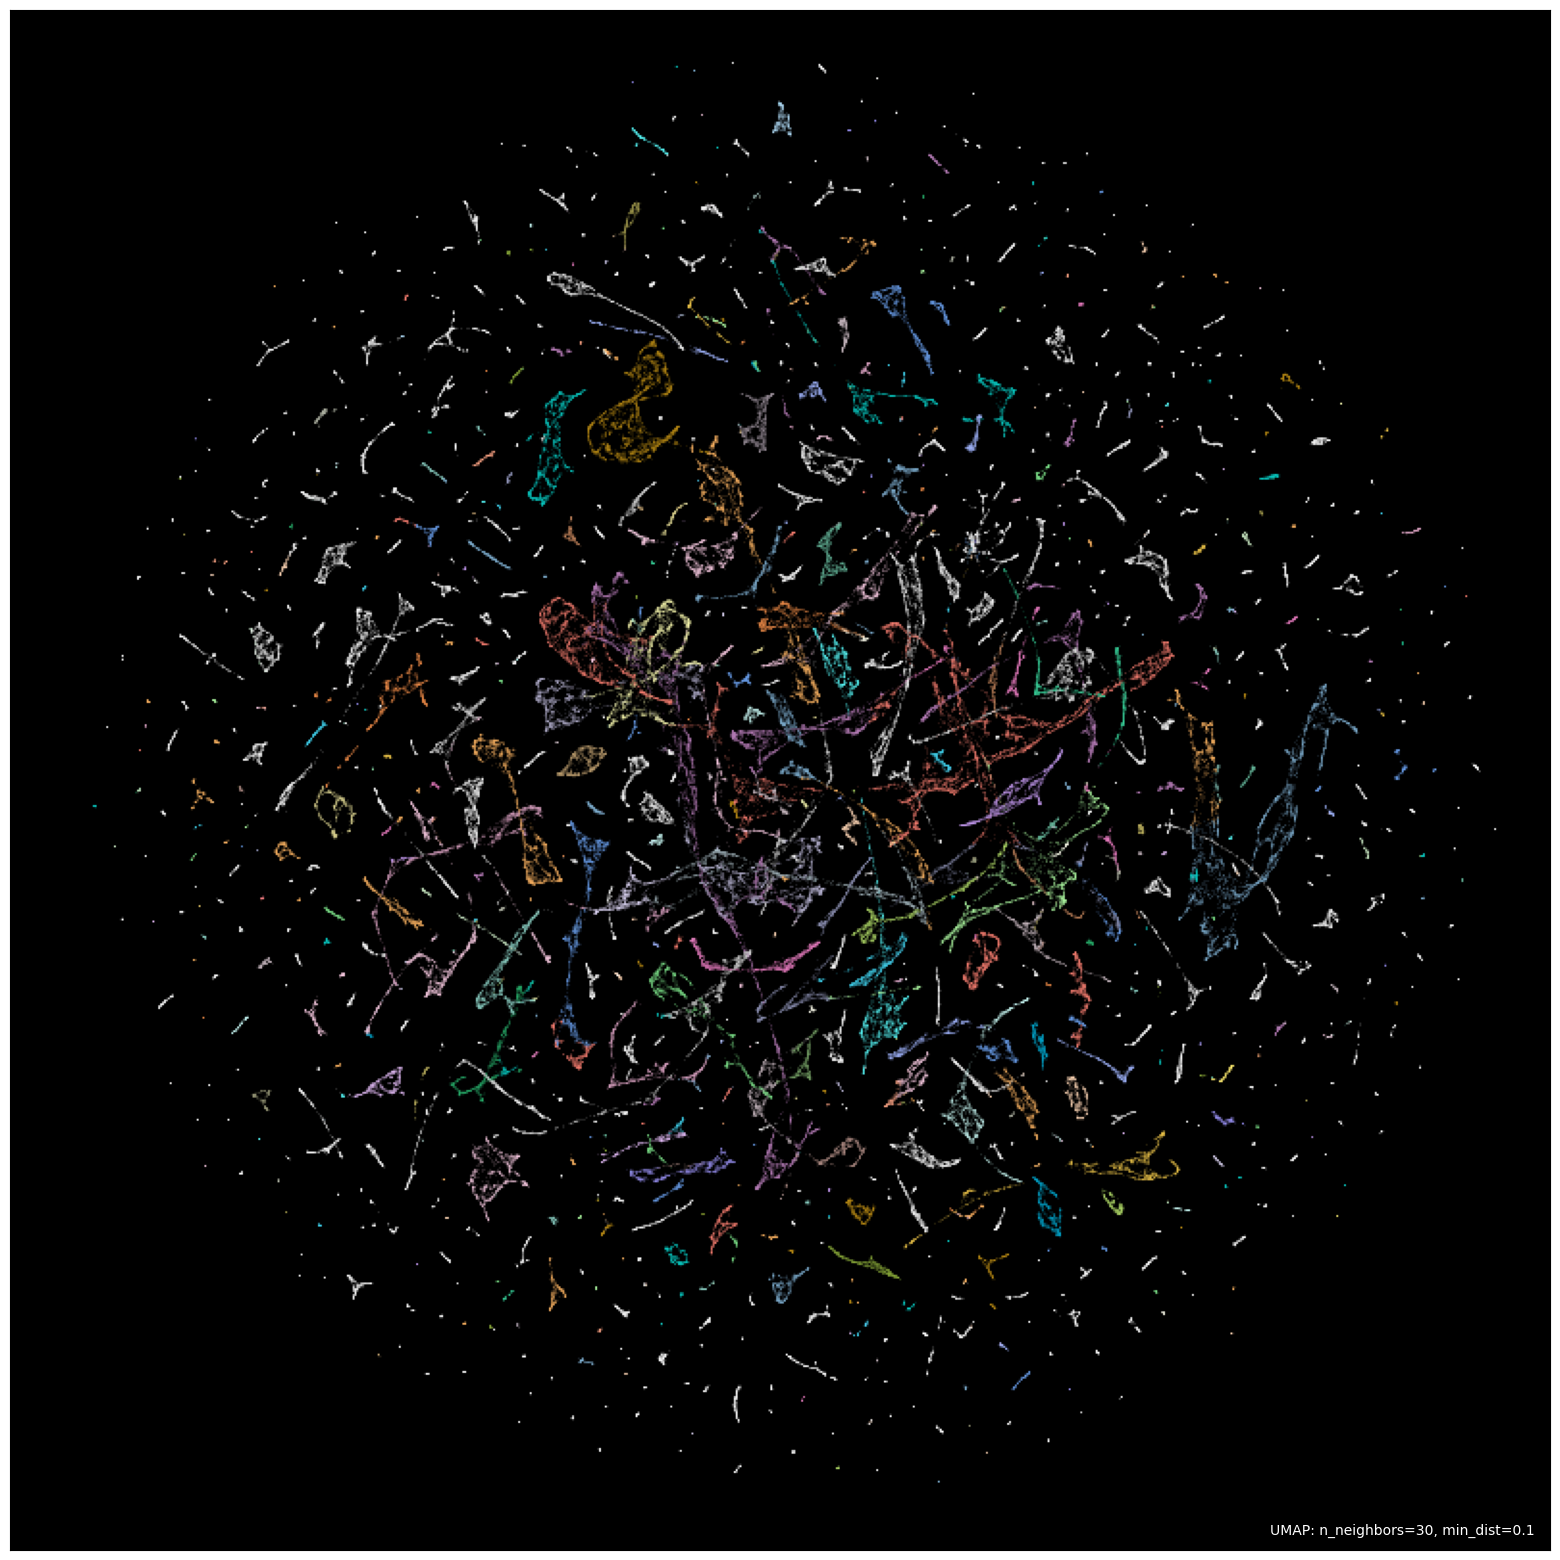

In [214]:
fig, ax = plt.subplots(figsize=(20, 20))
umap.plot.points(
    viz_reducer,
    labels=labels,
    background="black",
    color_key=cmap,
    show_legend=False,
    ax=ax,
)

<Axes: >

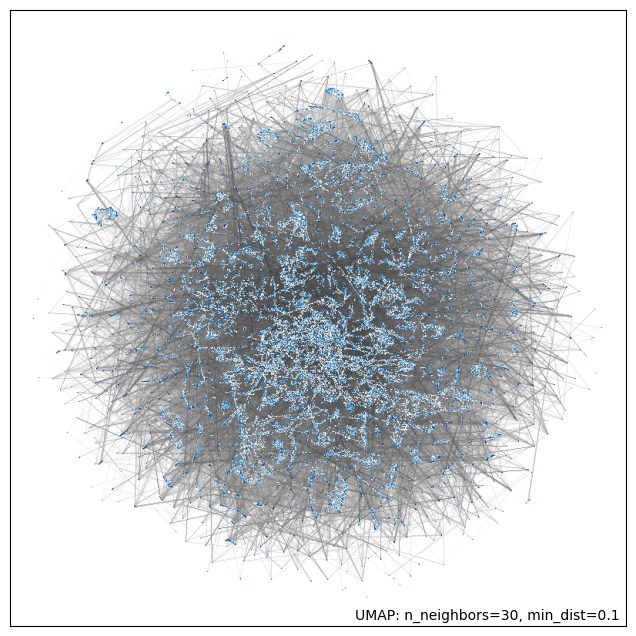

In [94]:
umap.plot.connectivity(viz_reducer, show_points=True)

In [ ]:
np.save(embedding)

In [ ]:
np.save("data/umap_prague_k7_n30_dim15.npy", embedding)

In [ ]:
embedding.shape

In [ ]:
np.load("data/umap_prague_k7_n30_dim15.npy").shape

In [63]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# kmeans_label = KMeans(n_clusters=9, max_iter=1000, n_init=500).fit(embedding[tess_groups_ilocs, :50]).labels_
# adjusted_rand_score(tess_groups.values, kmeans_label)

In [64]:
# plotting = gpd.GeoDataFrame(tess_groups.to_frame(),
#                             geometry=tessellation.iloc[tess_groups_ilocs].geometry)
# plotting.columns = ['neighbourhood', 'geometry']
# plotting['neighbourhood'] = kmeans_label
# plotting.explore(column='neighbourhood', categorical=True)

In [65]:
# tessellation.loc[X_different[X_different.duplicated()].index.values].explore()

### PCA tests and comparison

In [125]:
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.decomposition import PCA

In [126]:
%%time
pca_reducer = PCA(n_components=50)
pca_embedding = pca_reducer.fit_transform(X_train)

CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 169 ms


In [127]:
pca_reducer.explained_variance_ratio_.cumsum()

array([0.24724921, 0.34426064, 0.4120112 , 0.46486687, 0.50970801,
       0.5456924 , 0.57881828, 0.60832048, 0.63272279, 0.65300465,
       0.67245232, 0.68743875, 0.70078772, 0.71281703, 0.72365842,
       0.73410396, 0.74390661, 0.752653  , 0.76088783, 0.76873082,
       0.77615939, 0.78333236, 0.79018686, 0.79678487, 0.80284847,
       0.80876012, 0.81426011, 0.81965984, 0.82494845, 0.83002982,
       0.83472932, 0.8392281 , 0.84365725, 0.84800937, 0.85232751,
       0.856409  , 0.86026246, 0.86389958, 0.86741458, 0.87075579,
       0.87397614, 0.87707692, 0.88014533, 0.88310134, 0.88592769,
       0.88874063, 0.89138011, 0.89399364, 0.89649789, 0.89898161])

In [128]:
embedding_df = pd.DataFrame(pca_embedding[tess_groups_ilocs], index=tess_groups.index)
embedding_df["neighbourhood"] = tess_groups.values

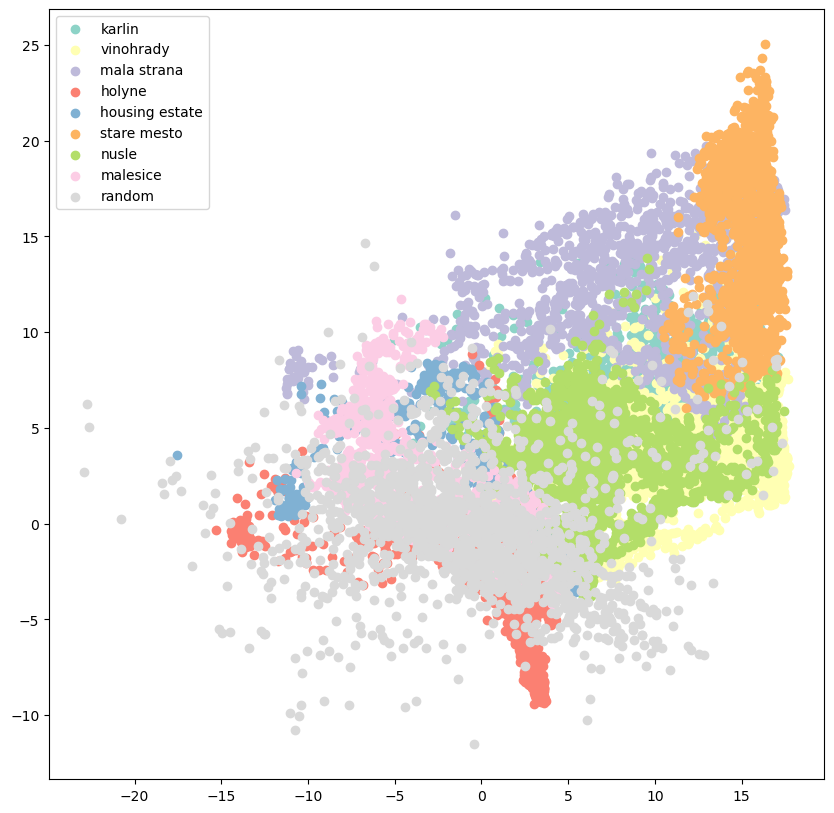

In [129]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :10]
    ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)

ax.legend()

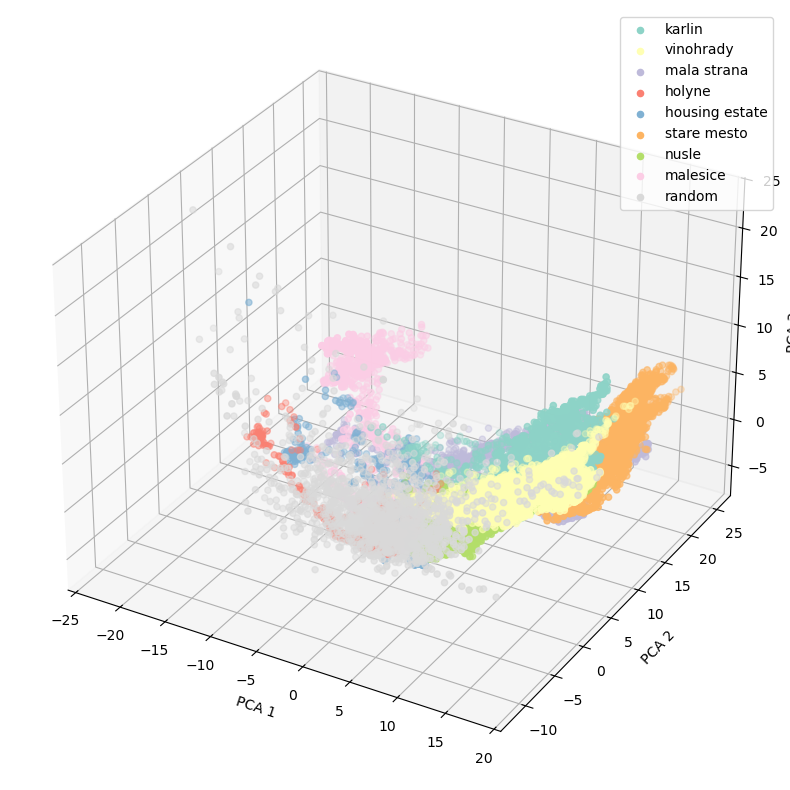

In [130]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:, 0], es_[:, 1], es_[:, 2], color=color, label=label)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend()

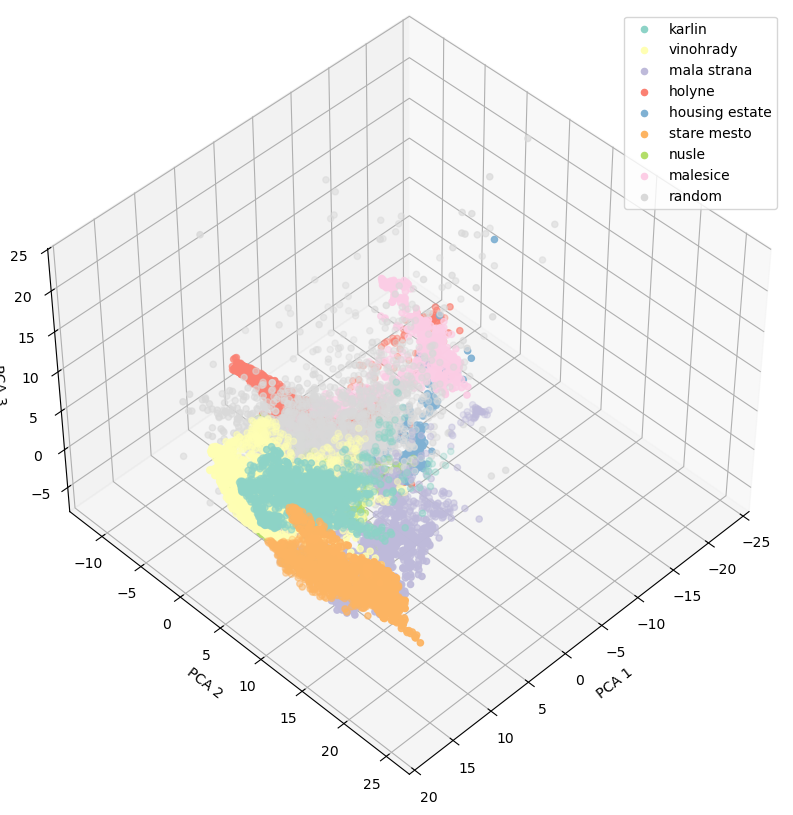

In [131]:
ax.view_init(45, 45)
fig

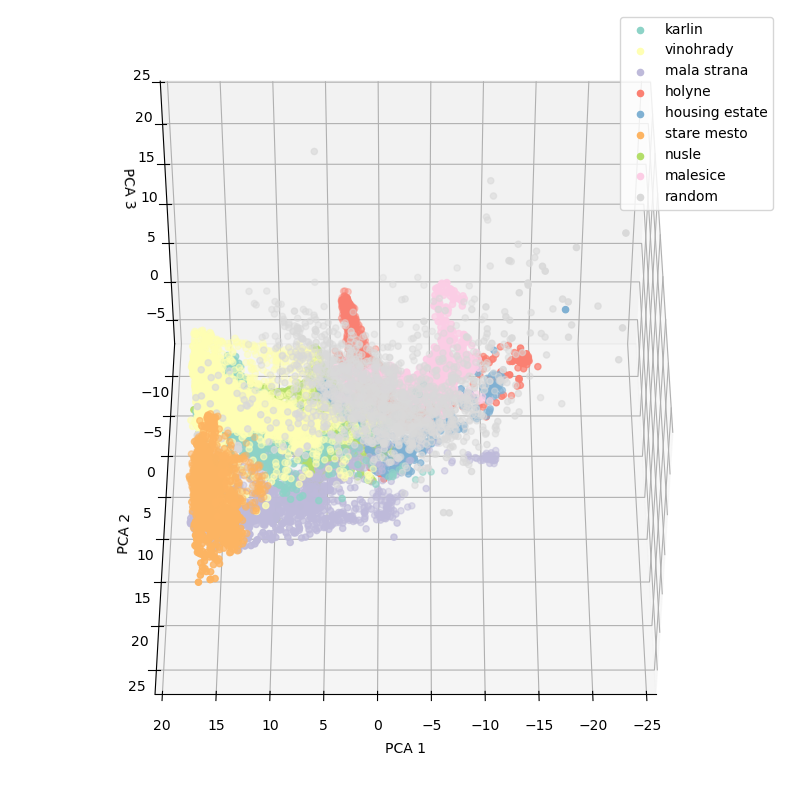

In [132]:
ax.view_init(45, 90)
fig

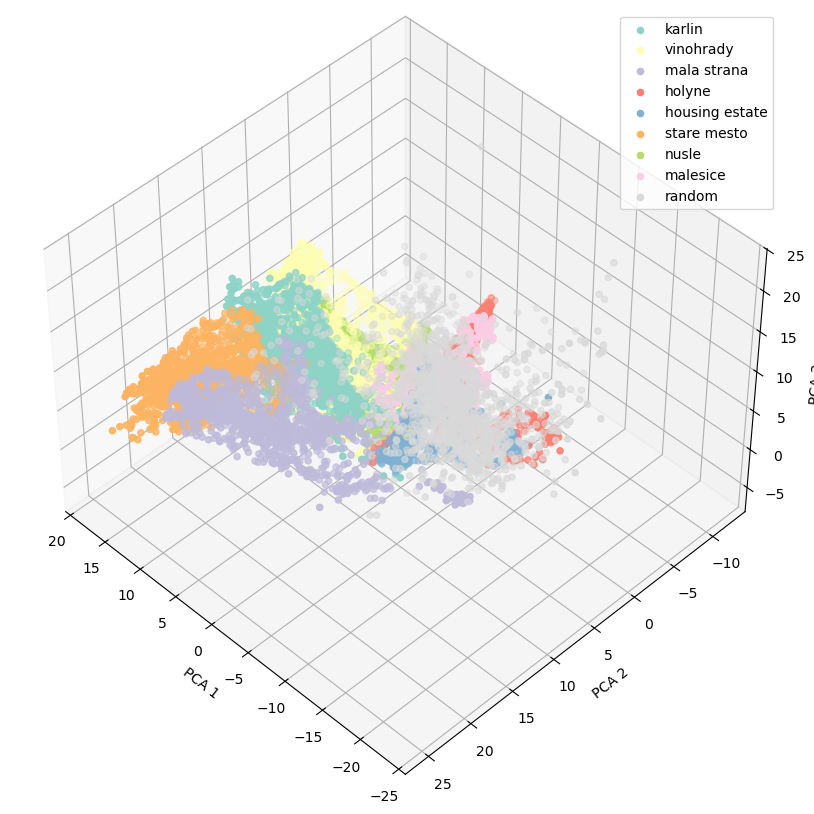

In [133]:
ax.view_init(45, 135)
fig

In [134]:
davies_bouldin_score(pca_embedding[tess_groups_ilocs, :5], tess_groups.values)

np.float64(2.6010371190661794)

In [135]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans_label = (
    KMeans(n_clusters=9, max_iter=1000, n_init=500)
    .fit(pca_embedding[tess_groups_ilocs, :50])
    .labels_
)
adjusted_rand_score(tess_groups.values, kmeans_label)

0.31979626215315715

In [136]:
colored_crosstab(tess_groups.values, kmeans_label)

In [83]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# kmeans_label = KMeans(n_clusters=9, max_iter=1000, n_init=500).fit(pca_embedding[:, :50]).labels_
# adjusted_rand_score(tess_groups.values, kmeans_label[tess_groups_ilocs])

In [421]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans_label = (
    KMeans(n_clusters=9, max_iter=1000, n_init=500)
    .fit(embedding[tess_groups_ilocs, :50])
    .labels_
)
adjusted_rand_score(tess_groups.values, kmeans_label)

0.6498999926696776

In [422]:
colored_crosstab(tess_groups.values, kmeans_label)

In [85]:
# plotting = gpd.GeoDataFrame(tess_groups.to_frame(),
#                             geometry=tessellation.iloc[tess_groups_ilocs].geometry)
# plotting.columns = ['neighbourhood', 'geometry']
# plotting['neighbourhood'] = kmeans_label
# plotting.explore(column='neighbourhood', categorical=True)

In [86]:
# np.save('../data/umap.npy', embedding)


In [87]:
# embedding = np.load('../data/umap.npy')

### HDBSCAN

In [11]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [12]:
min_cluster_size = 25

In [13]:
%%time
sklearn_tree = KDTree(embedding)

CPU times: user 245 ms, sys: 3.99 ms, total: 249 ms
Wall time: 248 ms


In [14]:
%%time
numba_tree = kdtree_to_numba(sklearn_tree)

CPU times: user 10 μs, sys: 0 ns, total: 10 μs
Wall time: 12.2 μs


In [15]:
%%time
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)

CPU times: user 43.1 s, sys: 4.1 ms, total: 43.1 s
Wall time: 3.24 s


In [16]:
sorted_mst = edges[np.argsort(edges.T[2])]

In [17]:
%%time
linkage_tree = mst_to_linkage_tree(sorted_mst)

CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 10.2 ms


In [18]:
condensed_tree = condense_tree(linkage_tree, min_cluster_size=300)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [19]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(tess_groups.values, clusters[tess_groups_ilocs])

NameError: name 'tess_groups' is not defined

In [20]:
np.unique(clusters, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

In [21]:
from lonboard import PolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [22]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = clusters
plotting = plotting[plotting["label"] >= 0]

In [23]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


if plotting["label"].max() > 12:
    gb_cols = glasbey.extend_palette(
        Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
    )
else:
    gb_cols = Set3_12.hex_colors

gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [24]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [26]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

#### Assign noise points to nearest cluster


In [27]:
from fast_hdbscan.numba_kdtree import parallel_tree_query
from fast_hdbscan.numba_kdtree import parallel_tree_query

In [28]:
clustered_data = X_train[clusters >= 0]
unclustered_data = X_train[clusters == -1]

In [29]:
%%time
sklearn_tree = KDTree(clustered_data)
numba_tree = kdtree_to_numba(sklearn_tree)

CPU times: user 2.84 s, sys: 40 ms, total: 2.88 s
Wall time: 2.86 s


In [30]:
%%time
distances, knns = parallel_tree_query(numba_tree, np.array(unclustered_data, order='C'), k=1)

CPU times: user 49min 53s, sys: 338 ms, total: 49min 54s
Wall time: 2min 47s


In [31]:
pd.Series(distances[:, 0]).describe()

count    32388.000000
mean         7.377885
std          3.484222
min          0.118299
25%          5.406506
50%          6.902147
75%          8.585401
max         33.738037
dtype: float64

In [32]:
new_labels = clusters.copy()

## which cluster should the noise points be assigned to
assignments = clusters[np.where(clusters >= 0)[0][knns[:, 0]]]

new_labels[new_labels == -1] = assignments

In [33]:
np.save('../data/sample_cluster_labels.npy', new_labels)

In [36]:
to_dissolve = tessellation.loc[X_train.index]

In [37]:
to_dissolve['cluster'] = new_labels

In [38]:
%%time
disolved = to_dissolve.dissolve('cluster')

CPU times: user 24.9 s, sys: 4.02 ms, total: 24.9 s
Wall time: 24.9 s


In [43]:
disolved.to_parquet('../data/sample_clusters.parquet')

#### assign duplicates to nearest cluster...

In [103]:
from sidecar import Sidecar
sc = Sidecar(title='buildings')

In [104]:
with sc:
    display(m)

## KMEANS

In [327]:
## append individual original data

# embedding = X_train
# embedding = X_train[[c for c in X_train.columns if 'median' in c]]

# to_add = primary.loc[X_train.index]
# to_add = np.nan_to_num(StandardScaler().fit_transform(to_add))
# to_add = pd.DataFrame(to_add, columns=primary.columns, index=X_train.index)
# to_add = to_add.clip(-10, 10)
# check_score(X, tess_groups)

# embedding = pd.concat((embedding, to_add), axis=1)

In [339]:
for k in range(2, 20):
    kmeans_label = (
    KMeans(n_clusters=k)
        .fit(embedding)
        .labels_
    )

    print(k, adjusted_rand_score(tess_groups.values, kmeans_label[tess_groups_ilocs]), davies_bouldin_score(X_train, kmeans_label))

2 0.07129563638382734 2.3098940125352603
3 0.09338713442766673 2.6850706079238678
4 0.09649103495946504 3.444775302980501
5 0.16793525079073277 3.0652300425579386
6 0.1669484075990239 3.242021988153553
7 0.1637277083178908 3.0882111567548605
8 0.17524594924472545 3.3554916874783434
9 0.1763492311606432 3.42452023125264
10 0.17021930241064007 3.59721199147248
11 0.17306801824746354 3.7996504216331157
12 0.17595656015748962 3.827398994720024
13 0.17354089228060707 3.92878532785172
14 0.1737801142876333 3.963259451819629
15 0.2636108017214465 3.704771344881667
16 0.26161383040828345 3.5916380027898933
17 0.2702512124090174 3.991032863858589
18 0.26701883576620655 3.596401248153047
19 0.2698922570160168 3.6328659060388118


In [ ]:
# kmeans_label = (
#     KMeans(n_clusters=18)
#         .fit(pca_embedding)
#         .labels_
#     )

In [340]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = kmeans_label

In [341]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


if plotting["label"].max() > 12:
    gb_cols = glasbey.extend_palette(
        Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
    )
else:
    gb_cols = Set3_12.hex_colors

gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [342]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [347]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [344]:
%%time
imps = get_feature_importance(X_train, kmeans_label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 co

CPU times: user 7min 35s, sys: 512 ms, total: 7min 35s
Wall time: 56.8 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


In [348]:
colored_crosstab(tess_groups.values, kmeans_label[tess_groups_ilocs])

In [346]:
selected = [0, 3, 4, 5, 14]
imps[np.concat([(f'cluster_{c}', f'cluster_{c}_vals') for c in selected])].iloc[:20, ]

cluster_0  cluster_0_vals      cluster_3  cluster_3_vals  \
0   ldsMSL_median        0.030502  ltkWNB_median        0.021411   
1   ldsMSL_higher        0.026578  ldsRea_higher        0.021040   
2   lddNDe_median        0.025996   ltcWRB_lower        0.015971   
3    linWID_lower        0.025448  sicCAR_median        0.015811   
4   lcnClo_median        0.024869  sicCAR_higher        0.015420   
5   ltkWNB_median        0.024487  mtbSWR_median        0.015274   
6   sicCAR_median        0.023215  ssbERI_median        0.015056   
7   linWID_median        0.019788  linP4W_median        0.014792   
8   lddNDe_higher        0.015543  lskERI_median        0.014318   
9    lddNDe_lower        0.014739  ltkWNB_higher        0.013932   
10  likWBB_higher        0.013640  ldsRea_median        0.013759   
11  ldkAre_higher        0.013191   ltbIBD_lower        0.013686   
12  likWBB_median        0.013167  sisBpM_median        0.013533   
13  lcdMes_median        0.012979  ldbPWL_higher        0.011985   
14  ldsAre_median        0.012411   lcnClo_lower        0.011332   
15  ldsRea_median        0.012036   sdcLAL_lower        0.010930   
16  sdsSPO_median        0.011678  ldkAre_median        0.010915   
17  ldkAre_median        0.010890  sisBpM_higher        0.010672   
18  mtdMDi_median        0.009964  ltcWRB_higher        0.010456   
19  linWID_higher        0.009562  lcnClo_median        0.010357   

        cluster_4  cluster_4_vals      cluster_5  cluster_5_vals  \
0   mtbSWR_median        0.049895  sdsSPW_median        0.052253   
1   sscCCo_median        0.039480  sdsSPW_higher        0.032805   
2    sscCCo_lower        0.025768  ltcWRB_higher        0.031095   
3   mtbSWR_higher        0.019675  sdbAre_median        0.023513   
4   ssbElo_higher        0.018821  sdbPer_median        0.022977   
5    sdcAre_lower        0.015657   ltcBuA_lower        0.021914   
6    mdcAre_lower        0.015135  sisBpM_median        0.021546   
7   sscCCo_higher        0.014583  sdbAre_higher        0.018103   
8   sscERI_higher        0.012939  mtbSWR_median        0.016338   
9   sdbPer_median        0.012826   mtbAli_lower        0.014928   
10  mtcWNe_higher        0.012773  sdcAre_median        0.014422   
11  mdcAre_median        0.012682  mtcWNe_median        0.013486   
12  sdcAre_median        0.011955  ldbPWL_median        0.012902   
13  ltcBuA_higher        0.011805  mdcAre_median        0.012222   
14  sicCAR_median        0.011448   ltbIBD_lower        0.012222   
15  ssbElo_median        0.011124  stbCeA_median        0.012039   
16  stcOri_higher        0.010386  ltcBuA_median        0.011184   
17  ltcBuA_median        0.010293  sdcAre_higher        0.010871   
18  ldbPWL_median        0.009527   sisBpM_lower        0.010863   
19  mtbNDi_median        0.009486   sscCCo_lower        0.010271   

       cluster_14  cluster_14_vals  
0   lddNDe_higher         0.029654  
1   ldsAre_median         0.027643  
2   ltkWNB_median         0.020776  
3   lskERI_median         0.019826  
4   ldkAre_median         0.016577  
5   ltcWRB_higher         0.016284  
6   ltkWNB_higher         0.015460  
7   linPDE_median         0.014412  
8   lddNDe_median         0.014342  
9   midAre_median         0.013297  
10  linPDE_higher         0.010881  
11  ldkPer_higher         0.009613  
12  ldkAre_higher         0.009243  
13  sdsLen_higher         0.009103  
14  ldsRea_median         0.008858  
15  likWBB_median         0.008648  
16   midAre_lower         0.008483  
17  ltcWRB_median         0.008029  
18   mtdDeg_lower         0.007889  
19  linWID_median         0.007659

In [ ]:
np.unique(np.concatenate(imps.iloc[:20].values)).shape

In [276]:
%%time
imps = get_feature_importance(X_train.iloc[tess_groups_ilocs], tess_groups.values)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 co

CPU times: user 5.53 s, sys: 52 ms, total: 5.58 s
Wall time: 991 ms


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [282]:
used_keys['ltbIBD']

'mean inter-building distance'

In [277]:
imps

cluster_holyne  cluster_holyne_vals cluster_housing estate  \
0   sisBpM_median             0.070093           linP3W_lower   
1   sdbAre_higher             0.069454           ltkWNB_lower   
2   lskCCo_higher             0.056759           stbOri_lower   
3   sdbAre_median             0.053034          sdsSPW_higher   
4    sdsSWD_lower             0.040668          sicCAR_higher   
5   sdbPer_median             0.033610          ltkOri_median   
6    sdbPer_lower             0.028895           midRea_lower   
7   midRea_median             0.027536          sisBpM_higher   
8   lskCCo_median             0.027500          lskCCo_median   
9    sisBpM_lower             0.027264           sdcLAL_lower   
10   mtbNDi_lower             0.026698          stbOri_higher   
11  sdsAre_higher             0.024294          sdsSPW_median   
12  lcnClo_median             0.022763          lcdMes_higher   
13  sdsSWD_median             0.020147           sdsSPW_lower   
14  ldbPWL_higher             0.018485           ltcWRB_lower   
15  sdbPer_higher             0.018447          ltbIBD_median   
16   mdcAre_lower             0.017336          sicCAR_median   
17  linP3W_median             0.014662          sdbAre_median   
18  ldkPer_higher             0.013616          lddNDe_median   
19   stbCeA_lower             0.012427          ltcBuA_higher   
20  ldsAre_higher             0.011709          linWID_median   
21  midAre_higher             0.011204          ldkAre_median   
22   ldbPWL_lower             0.010831          ltcWRB_higher   
23   likWBB_lower             0.010750          lddNDe_higher   
24   lskERI_lower             0.010687          stbCeA_median   
25  ldsAre_median             0.009929          midRea_higher   
26  sdsLen_higher             0.009451          likWBB_higher   
27  linP3W_higher             0.009138           linPDE_lower   
28   lskCCo_lower             0.008975           ltbIBD_lower   
29  ssbERI_higher             0.008379          ssbCCo_higher   
30  mtdDeg_higher             0.008290           mtbNDi_lower   
31  lddNDe_median             0.008267           ltcBuA_lower   
32  linPDE_higher             0.008176           ldbPWL_lower   
33   ssbCCo_lower             0.008140          linP3W_median   
34  ldsMSL_higher             0.008024          ssbCCD_higher   
35   sdsLen_lower             0.007857          ltbIBD_higher   
36  linP4W_median             0.007822          sdbPer_median   
37  lskERI_higher             0.007439          ssbSqu_median   
38  ldkAre_higher             0.007437          ldbPWL_higher   
39  ltkWNB_median             0.007111           ssbCCo_lower   
40  mtbSWR_higher             0.006297           ltkOri_lower   
41  lcnClo_higher             0.006061          stbOri_median   
42  xcnSCl_higher             0.006039           likWBB_lower   
43  mtbAli_median             0.005696          ssbElo_higher   
44  mdcAre_median             0.005309           lcnClo_lower   
45  stbCeA_higher             0.005142           ssbElo_lower   
46  mtbAli_higher             0.005106          xcnSCl_higher   
47  lcdMes_median             0.004960           mdcAre_lower   
48  sdsSPW_median             0.004869          sdbAre_higher   
49   linP4W_lower             0.004828           lskCCo_lower   

    cluster_housing estate_vals cluster_karlin  cluster_karlin_vals  \
0                      0.047580  linP4W_median             0.062065   
1                      0.040011   lskCCo_lower             0.044546   
2                      0.036318  stbOri_higher             0.036034   
3                      0.027410  ltkOri_median             0.033518   
4                      0.023709   stcOri_lower             0.033158   
5                      0.022764  ssbCCo_higher             0.027286   
6                      0.022096   linP4W_lower             0.026955   
7                      0.021197   ltkOri_lower             0.025936   
8                      0.020633  ssbERI_higher  

## DBSCAN 

In [397]:
embedding = X_train[[c for c in X_train.columns if '_median' in c]]

In [398]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score

In [399]:
clustering_graph = graph.subgraph(X_train.index.values).transform('B').sparse

In [400]:
clusterer = AgglomerativeClustering(linkage='single',
                                    connectivity=clustering_graph, 
                                    compute_full_tree=True, compute_distances=True)

In [401]:
%%time
model = clusterer.fit(embedding)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:594: UserWarning: the number of connected components of the connectivity matrix is 1330 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(

KeyboardInterrupt

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 141, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [402]:
def get_linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

In [403]:
linkage_matrix = get_linkage_matrix(model)

KeyboardInterrupt: 

In [ ]:
fix, ax = plt.subplots(figsize=(40,40))
# Plot the corresponding dendrogram
_ = dendrogram(linkage_matrix, truncate_mode="level", p=5, ax=ax)

In [ ]:
for t in range(10, 25, 1):
    r = fcluster(linkage_matrix, t=t, criterion='distance')
    # r = pd.Series(r, index=X_train.index)
    # # ssplits = graph.describe(r, statistics=['nunique'])['nunique']
    print(t, ' - ', 
          adjusted_rand_score(tess_groups.values, r[tess_groups_ilocs]),
          # (ssplits > 1).sum() / ssplits.shape[0],
          davies_bouldin_score(X_train, r)
         )

In [392]:
clusters = fcluster(linkage_matrix, t=10, criterion='distance')

In [394]:
np.unique(clusters, return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

In [393]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = clusters

In [341]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


if plotting["label"].max() > 12:
    gb_cols = glasbey.extend_palette(
        Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
    )
else:
    gb_cols = Set3_12.hex_colors

gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [342]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [347]:
m = Map(layer, basemap_style=CartoBasemap.Positron)
m